### Importing stuff we need

In [84]:
from typing import Optional
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from sim import cryosim as cryo

### Setting up the RL environment

In [98]:
class DetectorEnvDiscrete(gym.Env):
    """A very simplified detector environment"""

    def __init__(self, n_levels = 10, max_steps=50):
        super().__init__()
        self.n_levels = n_levels
        self.max_steps = max_steps
        self.state = None
        self.steps = 0

        self.observation_space = spaces.Box(
            low=0.0, high=np.inf, shape=(1,), dtype=np.float32
        )

        # configurations
        self.dac_min, self.dac_max = 0.0, 1e-5
        self.dac_step = 1e-7
        self.start_dac = 2e-7

        # 7 actions: {-5,-3,-1,0,+1,+3,+5} * step
        self.delta_table = np.array([-5, -3, -1, 0, +1, +3, +5], dtype=int)
        self.action_space = spaces.Discrete(len(self.delta_table))

        # bias & TP fixed
        self.bias_v = 2e-6
        self.tpa    = 200e-9

        # simulator + fixed controls
        self.sim = cryo.Cryosim(record_length=2**14, sample_frequency=50e3, default=True)
        self.dac = self.start_dac
        self.sim.set_heater_tp(tp_amplitude=self.tpa)
        self.sim.set_bias(bias_voltage=self.bias_v)
        self.sim.set_heater(self.dac)
        self.sim.solve()

    def _observe(self):
        ph = float(np.max(self.sim.I_T) - np.min(self.sim.I_T))
        return np.array([ph], dtype=np.float32)

    def step(self, action):
        delta = self.delta_table[int(action)]

        # update DAC and clip
        self.dac = float(np.clip(self.dac + delta * self.dac_step,
                                self.dac_min, self.dac_max))

        # apply settings and solve
        self.sim.set_heater(self.dac)
        self.sim.set_heater_tp(tp_amplitude=self.tpa)
        self.sim.set_bias(bias_voltage=self.bias_v)
        self.sim.solve()

        obs = self._observe()
        scale = 1e6
        reward = scale * float(obs[0])
        self.steps += 1

        terminated = False
        truncated = (self.steps >= self.max_steps)
        info = {"dac": self.dac}
        return obs, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        self.steps = 0
        self.dac = self.start_dac
        self.sim.set_heater(self.dac)
        self.sim.set_heater_tp(tp_amplitude=self.tpa)
        self.sim.set_bias(bias_voltage=self.bias_v)
        self.sim.solve()
        obs = self._observe()
        return obs, {}

In [99]:
try: del env
except: pass
env = DetectorEnvDiscrete(max_steps=15)
print("bias_v", env.bias_v, "tpa", env.tpa, "start_dac", env.start_dac)

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.15 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
Cryogenic simulation initialized with default components.
bias_v 2e-06 tpa 2e-07 start_dac 2e-07


### Sampling some random actions to see if the environment works

In [100]:
env = DetectorEnvDiscrete(max_steps=15)
obs, _ = env.reset()
print("Initial:", obs, "DAC", env.dac)
for _ in range(6):
    a = env.action_space.sample()
    obs, r, term, trunc, info = env.step(a)
    print(f"a={a} dac={info['dac']:.2e} ph={obs[0]:.3e} r={r:.3e}")

Heater initialized with R_H = 0.01 Ohms
TES initialized with model=sigmoid, R_max=0.15 Ohm, T_mid=0.035 K
ETM initialized as 2-component model with parameters: C_e=2.2e-11, C_a=1.5e-10, G_eb=7.5e-09, G_ea=1.4e-10, G_ab=5e-09, T_b=0.015, R_S=0.05, L=4e-07, V_B=5e-06
Cryogenic simulation initialized with default components.
Initial: [8.668275e-07] DAC 2e-07
a=5 dac=5.00e-07 ph=3.249e-06 r=3.249e+00
a=2 dac=4.00e-07 ph=2.135e-06 r=2.135e+00
a=2 dac=3.00e-07 ph=1.377e-06 r=1.377e+00
a=4 dac=4.00e-07 ph=2.135e-06 r=2.135e+00
a=0 dac=0.00e+00 ph=2.361e-07 r=2.361e-01
a=4 dac=1.00e-07 ph=5.090e-07 r=5.090e-01


### Figuring out realistic state values (= the range of PHs we expect, so we can bin them)

PH range from sweep: 2.689082123969186e-07 → 2.875837893916104e-07


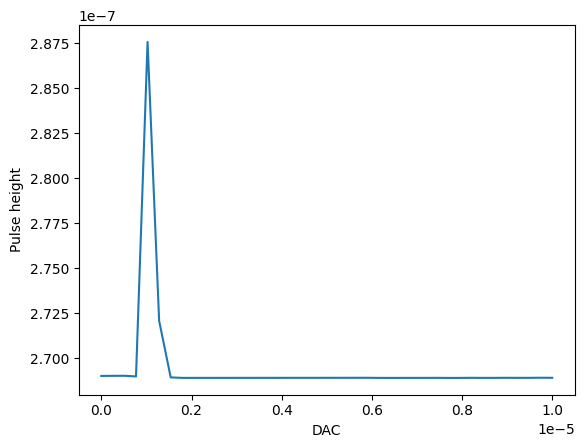

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def build_ph_sweep(env, lo=None, hi=None, n_points=40):
    sim = env.sim
    # use the env’s current TPA/bias
    sim.set_heater_tp(tp_amplitude=env.tpa)
    sim.set_bias(bias_voltage=env.bias_v)

    lo = env.dac_min if lo is None else lo
    hi = env.dac_max if hi is None else hi

    xs = np.linspace(lo, hi, n_points)
    ys = []
    for v in xs:
        sim.set_heater(v)
        sim.solve()
        ys.append(float(np.max(sim.I_T) - np.min(sim.I_T)))
    return xs, np.array(ys)

dac_vals, ph_list = build_ph_sweep(env, n_points=40)
print("PH range from sweep:", ph_list.min(), "→", ph_list.max())
plt.plot(dac_vals, ph_list); plt.xlabel("DAC"); plt.ylabel("Pulse height"); plt.show()


In [105]:
def collect_ph_rollouts(env, episodes=10, steps=20):
    phs = []
    for _ in range(episodes):
        obs, _ = env.reset()
        phs.append(float(obs[0]))
        for _ in range(steps):
            a = env.action_space.sample()
            obs, r, term, trunc, info = env.step(a)
            phs.append(float(obs[0]))
            if term or trunc:
                break
    return np.array(phs)


ph_samples = collect_ph_rollouts(env, episodes=12, steps=25)

# Build quantile bins from what the agent actually sees
n_states = 10
bin_edges = np.quantile(ph_samples, np.linspace(0, 1, n_states + 1))

def obs_to_state(obs):
    ph = float(obs[0])
    return int(np.clip(np.digitize(ph, bin_edges[1:-1]), 0, n_states - 1))

# Checking the binning
o, _ = env.reset()
print("Init:", o[0], "-> bin", obs_to_state(o))
for _ in range(6):
    a = env.action_space.sample()
    o, r, term, trunc, info = env.step(a)
    print(f"DAC={info['dac']:.2e}  PH={o[0]:.3e}  bin={obs_to_state(o)}")

Init: 8.668275e-07 -> bin 5
DAC=5.00e-07  PH=3.249e-06  bin=7
DAC=5.00e-07  PH=3.249e-06  bin=7
DAC=1.00e-06  PH=6.048e-06  bin=8
DAC=1.50e-06  PH=5.747e-07  bin=4
DAC=1.60e-06  PH=2.689e-07  bin=3
DAC=2.10e-06  PH=2.358e-09  bin=0


### Q-learning

In [ ]:
import numpy as np

# Shapes
n_actions = env.action_space.n               # 7 actions
Q = np.zeros((n_states, n_actions), dtype=np.float32)

# Hyperparameters (to be tuned later)
alpha   = 0.2       # learning rate
gamma   = 0.99      # discount
eps     = 1.0       # exploration probability
eps_min = 0.05
eps_decay = 0.995   # decay ε each episode

rng = np.random.default_rng(0)

def choose_action(s, Q, eps):
    """ε-greedy policy over the current Q-table."""
    if rng.random() < eps:
        return env.action_space.sample()
    return int(np.argmax(Q[s]))

In [110]:
def train_one_episode(Q, eps, alpha, gamma, verbose_first_steps=5):
    obs, _ = env.reset()
    s = obs_to_state(obs)
    done = False
    G = 0.0
    t = 0

    while not done:
        a = choose_action(s, Q, eps)
        obs2, r, terminated, truncated, info = env.step(a)
        s2 = obs_to_state(obs2)

        # Q-learning update:
        # Q[s,a] ← Q[s,a] + α [ r + γ max_a' Q[s2,a'] − Q[s,a] ]
        td_target = r + gamma * np.max(Q[s2])
        Q[s, a] += alpha * (td_target - Q[s, a])

        if t < verbose_first_steps:
            print(f"t={t:02d} | s={s:2d} a={a} -> s'={s2:2d} | r={r:.3e} | Q[{s},{a}]={Q[s,a]:.3e} | DAC={info['dac']:.2e}")

        G += r
        s = s2
        t += 1
        done = terminated or truncated

    return G

In [111]:
_ = train_one_episode(Q, eps=1.0, alpha=alpha, gamma=gamma, verbose_first_steps=8)

t=00 | s= 5 a=0 -> s'= 2 | r=2.361e-01 | Q[5,0]=4.721e-02 | DAC=0.00e+00
t=01 | s= 2 a=1 -> s'= 2 | r=2.361e-01 | Q[2,1]=4.721e-02 | DAC=0.00e+00
t=02 | s= 2 a=2 -> s'= 2 | r=2.361e-01 | Q[2,2]=5.656e-02 | DAC=0.00e+00
t=03 | s= 2 a=1 -> s'= 2 | r=2.361e-01 | Q[2,1]=9.618e-02 | DAC=0.00e+00
t=04 | s= 2 a=3 -> s'= 2 | r=2.361e-01 | Q[2,3]=6.625e-02 | DAC=0.00e+00
t=05 | s= 2 a=4 -> s'= 4 | r=5.090e-01 | Q[2,4]=1.018e-01 | DAC=1.00e-07
t=06 | s= 4 a=6 -> s'= 8 | r=4.728e+00 | Q[4,6]=9.456e-01 | DAC=6.00e-07
t=07 | s= 8 a=4 -> s'= 9 | r=6.249e+00 | Q[8,4]=1.250e+00 | DAC=7.00e-07


In [ ]:
# Learning curve + diagnostics
episodes = 40 # for 40 episodes with 15 steps it runs about 30 minutes on my computer
returns = []
state_visits = np.zeros(n_states, dtype=np.int64)
action_counts = np.zeros(env.action_space.n, dtype=np.int64)

eps = 1.0
for ep in range(episodes):
    obs, _ = env.reset()
    s = obs_to_state(obs)
    done = False
    G = 0.0
    while not done:
        a = choose_action(s, Q, eps)
        obs2, r, term, trunc, info = env.step(a)
        s2 = obs_to_state(obs2)

        td_target = r + gamma * np.max(Q[s2])
        Q[s, a] += alpha * (td_target - Q[s, a])

        state_visits[s] += 1
        action_counts[a] += 1
        G += r
        s = s2
        done = term or trunc
    returns.append(G)
    eps = max(eps_min, eps * eps_decay)

print("Mean return (last 10):", float(np.mean(returns[-10:])))

Mean return (last 10): 36.622040445732914


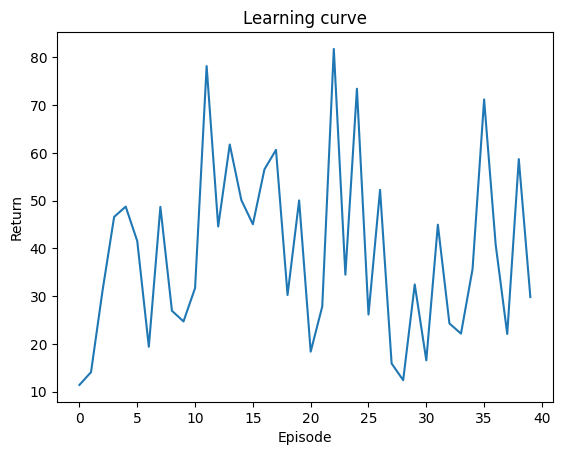

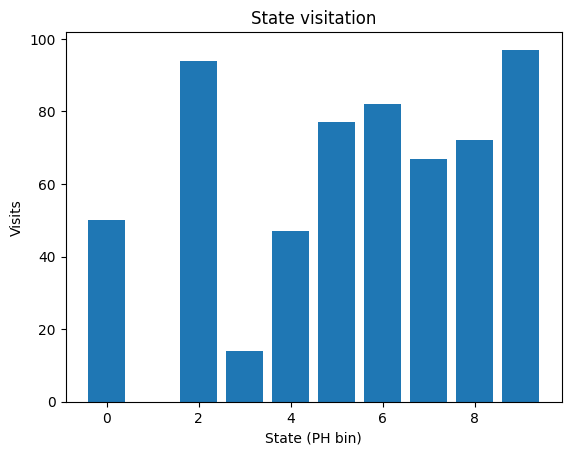

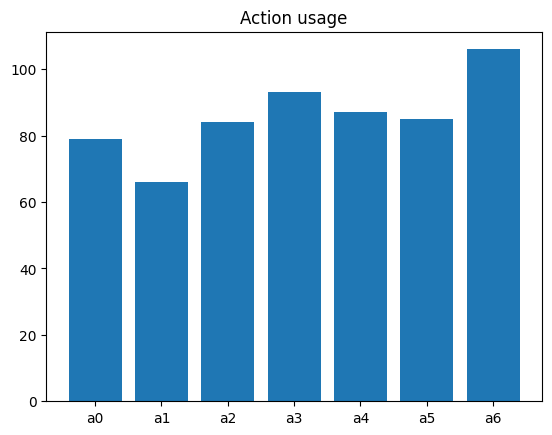

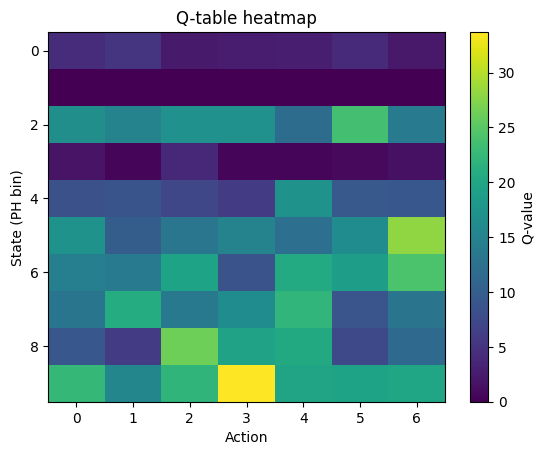

In [113]:
# Plots
import matplotlib.pyplot as plt, numpy as np

plt.figure(); plt.plot(returns); plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Learning curve"); plt.show()
plt.figure(); plt.bar(np.arange(n_states), state_visits); plt.xlabel("State (PH bin)"); plt.ylabel("Visits"); plt.title("State visitation"); plt.show()
plt.figure(); plt.bar([f"a{i}" for i in range(env.action_space.n)], action_counts); plt.title("Action usage"); plt.show()

plt.figure(); plt.imshow(Q, aspect="auto"); plt.colorbar(label="Q-value")
plt.xlabel("Action"); plt.ylabel("State (PH bin)"); plt.title("Q-table heatmap"); plt.show()

### Testing out the policy

In [114]:
obs, _ = env.reset()
done = False
while not done:
    s = obs_to_state(obs)
    a = int(np.argmax(Q[s]))
    obs, r, term, trunc, info = env.step(a)
    print(f"greedy: state={s:2d} best_a={a} | DAC={info['dac']:.2e} | PH={obs[0]:.3e} | r={r:.3e}")
    done = term or trunc

greedy: state= 5 best_a=6 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 best_a=3 | DAC=7.00e-07 | PH=6.249e-06 | r=6.249e+00
greedy: state= 9 bes

### Quick check of the bins

In [107]:
for i in range(n_states):
    print(f"Bin {i}: {bin_edges[i]:.3e} → {bin_edges[i+1]:.3e}")

Bin 0: 1.322e-12 → 2.361e-07
Bin 1: 2.361e-07 → 2.361e-07
Bin 2: 2.361e-07 → 2.459e-07
Bin 3: 2.459e-07 → 5.090e-07
Bin 4: 5.090e-07 → 8.668e-07
Bin 5: 8.668e-07 → 1.377e-06
Bin 6: 1.377e-06 → 3.249e-06
Bin 7: 3.249e-06 → 4.678e-06
Bin 8: 4.678e-06 → 6.249e-06
Bin 9: 6.249e-06 → 7.145e-06
